In [1]:
# import pandas, numpy and pycaret
import pandas as pd
import numpy as np
from pycaret.regression import *
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

df = pd.read_csv('data/train.csv')
df.columns = df.columns.str.lower()
df.drop('id', inplace=True, axis=1) 
df.head()

,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2309
[LightGBM] [Info] Number of data points in the train set: 1145, number of used features: 117
[LightGBM] [Info] Start training from score 179592.180786


,Description,Value
0,Session id,42
1,Target,saleprice
2,Target type,Regression
3,Original data shape,"(1432, 80)"
4,Transformed data shape,"(1432, 16)"
5,Transformed train set shape,"(1145, 16)"
6,Transformed test set shape,"(287, 16)"
7,Ordinal features,21
8,Numeric features,36
9,Categorical features,43


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,18193.3032,695793197.2914,26135.1010,0.8551,0.1384,0.1047,0.6200
et,Extra Trees Regressor,18209.4079,714878752.7183,26573.7099,0.8490,0.1386,0.1046,1.1550
lightgbm,Light Gradient Boosting Machine,18750.4973,745428822.9021,27125.1450,0.8445,0.1410,0.1070,0.6330
rf,Random Forest Regressor,18957.7277,769449638.3487,27512.2520,0.8388,0.1433,0.1088,1.2690
dt,Decision Tree Regressor,26723.8821,1555068796.5444,39014.3508,0.6757,0.2025,0.1531,2.9030


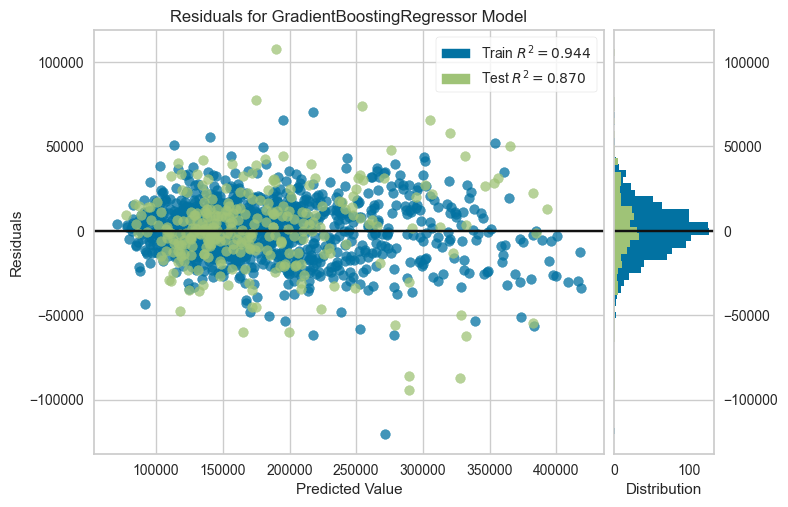

In [23]:
# setup pycaret model
df.drop(columns= 'log_saleprice', inplace=True)
exp1 = setup(df, target='saleprice', session_id=42, 
             numeric_imputation='median',
             rare_to_value=.1, 
             bin_numeric_features=['yearbuilt', 'yearremodadd', 'garageyrblt'],
             feature_selection=True, 
            #  feature_selection_method= 'sequential',  # Enable feature selection
            #  pca= True, # Enable PCA
             remove_multicollinearity=True, multicollinearity_threshold=.8, # Enable multicollinearity detection
             normalize=True, normalize_method='robust', # Enable normalization
            #  polynomial_features=True,  # Enable polynomial features
             train_size=0.8,  # Adjust the train-test split ratio
             )
# benchmark models
best_model = compare_models(include = ['dt', 'rf', 'et', 'gbr',  'lightgbm'], fold=10, round=4)
plot_model(best_model)

In [24]:
# Creating final model
dt = create_model(best_model)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:20:12
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,15345.8777,398803983.3793,19970.0772,0.8834,0.1141,0.0913
1,18244.0648,780034779.5985,27929.1027,0.8574,0.1478,0.1068
2,20465.2441,936479071.2275,30601.9455,0.8262,0.1387,0.1058
3,17449.6092,588729268.9442,24263.7439,0.8505,0.1259,0.0984
4,19447.4358,1077997776.3197,32832.8765,0.7556,0.1576,0.1115
5,18460.6977,656029088.4764,25613.0648,0.8486,0.1561,0.1207
6,19056.1358,719960712.6312,26832.0836,0.8717,0.1375,0.1047
7,18984.5282,604104197.7047,24578.5312,0.8721,0.1525,0.1217
8,16339.9565,497397089.1968,22302.4010,0.8967,0.1254,0.0925


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,14161.4884,314458303.8573,17732.9722,0.9080,0.1083,0.0868
1,17311.9201,723042105.0903,26889.4423,0.8678,0.1391,0.1019
2,19047.6309,827132422.2554,28759.9100,0.8465,0.1291,0.0988
3,17164.0889,671607927.1837,25915.3994,0.8294,0.1277,0.0941
4,17160.2155,749869270.3214,27383.7410,0.8300,0.1375,0.0990
5,17471.8613,742350927.6881,27246.1177,0.8287,0.1586,0.1139
6,18996.9715,771710205.0465,27779.6725,0.8625,0.1363,0.1021
7,17933.8379,678907255.5595,26055.8488,0.8563,0.1467,0.1114
8,17316.9792,555368136.9973,23566.2500,0.8847,0.1288,0.0979


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


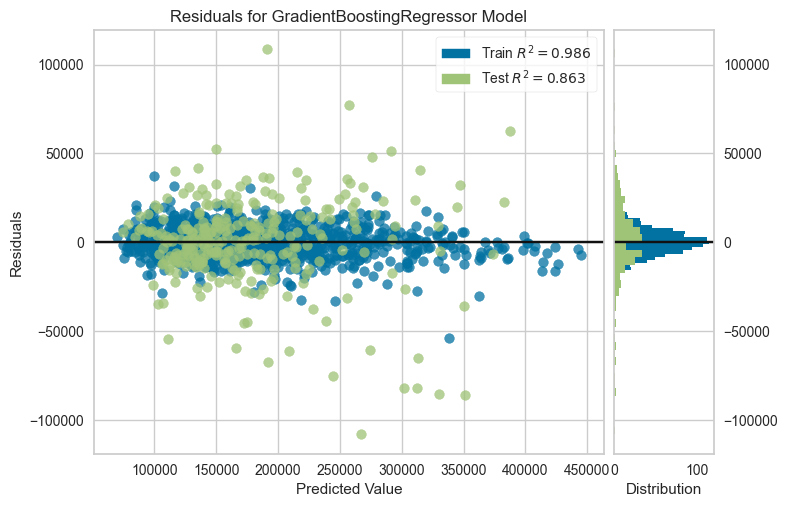

In [25]:
# Tune model hyperparameters
search_params = {'n_estimators': [100, 500, 1000], 'learning_rate': np.arange(0.01, 0.1, 0.05)}
tuned_dt = tune_model(dt, optimize='mae')
plot_model(tuned_dt)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:23:51
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,14888.4553,369701704.3016,19227.6287,0.8919,0.1107,0.0882
1,18109.6842,725828771.3189,26941.2095,0.8673,0.1416,0.1059
2,18692.6706,846173617.1318,29089.0635,0.8430,0.1308,0.0968
3,17172.2410,557378776.4923,23608.8707,0.8584,0.1251,0.0979
4,19011.4106,917141961.1941,30284.3518,0.7921,0.1491,0.1087
5,18707.8932,866370275.3580,29434.1685,0.8001,0.1647,0.1233
6,19432.6051,746773463.9854,27327.1562,0.8670,0.1400,0.1075
7,19350.9314,657167859.9787,25635.2854,0.8609,0.1531,0.1222
8,16326.5555,487565206.9319,22080.8788,0.8988,0.1225,0.0922


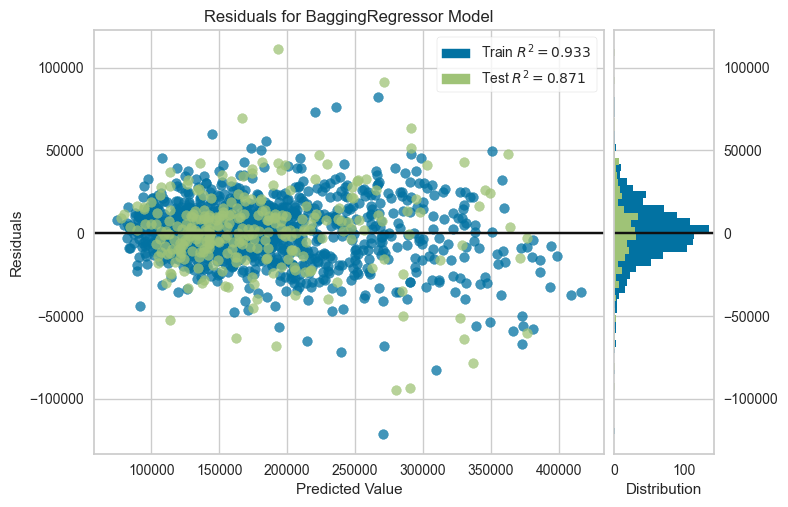

In [31]:
# Ensemble model with Bagging
bagging_dt = ensemble_model(dt, method = 'Bagging')
plot_model(bagging_dt)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,13713.7897,292506822.3219,17102.8308,0.9144,0.1074,0.0855
1,17970.0864,721489380.3116,26860.5544,0.8681,0.1398,0.1053
2,19233.1998,854254525.0871,29227.6329,0.8415,0.1298,0.0985
3,17033.8737,604004416.6337,24576.5013,0.8466,0.1250,0.0950
4,18230.2666,862268707.1219,29364.4123,0.8045,0.1477,0.1062
5,17753.8761,726564395.4476,26954.8585,0.8323,0.1588,0.1164
6,19506.8300,728162730.3512,26984.4906,0.8703,0.1365,0.1062
7,17838.6880,610967227.8653,24717.7513,0.8707,0.1413,0.1112
8,17345.1137,555032788.3006,23559.1339,0.8848,0.1328,0.1001


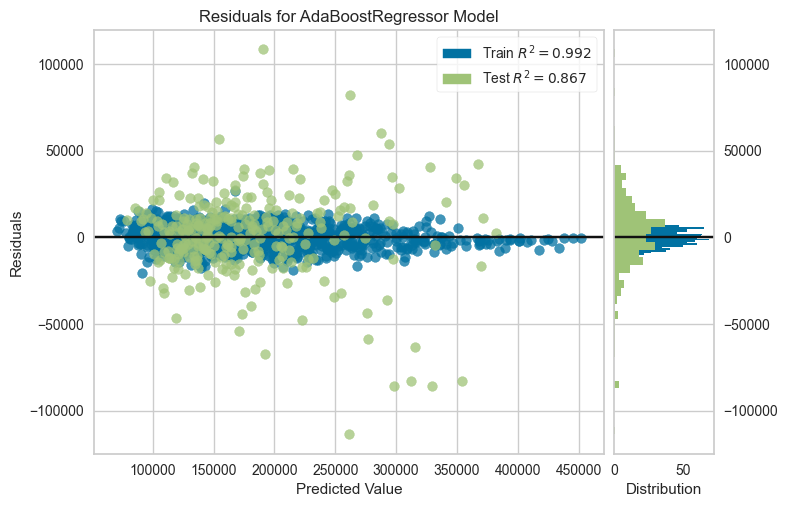

In [27]:
# Ensemble model with Boosting
boost_dt = ensemble_model(tuned_dt, method = 'Boosting')
plot_model(boost_dt)

In [32]:
# Blend models
final_model = finalize_model(bagging_dt)

# Load test data
df_test = pd.read_csv('data/test.csv')
df_test.columns = df_test.columns.str.lower()
df_test.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


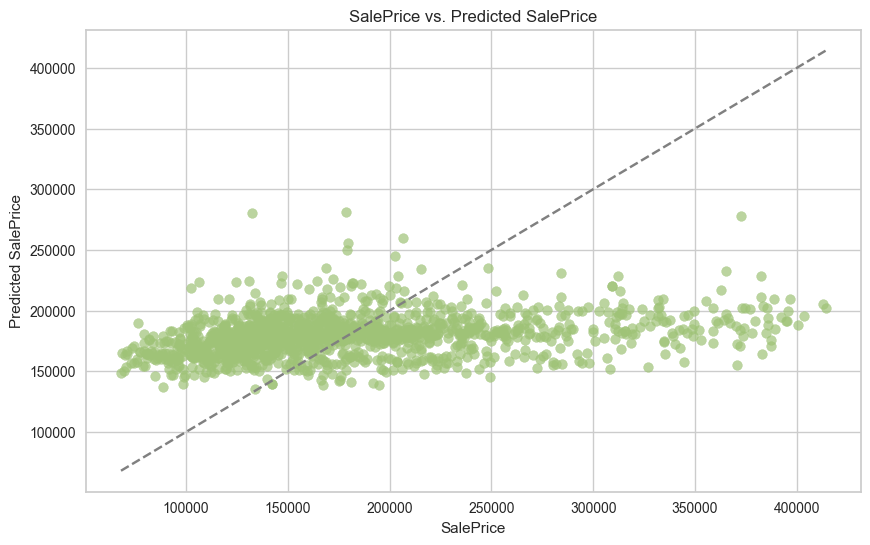

In [33]:
# predict salesprice for df_test
df_result = predict_model(final_model, data=df_test.drop('id', axis=1))

# Comparing real results
df_result['id'] = df_test['id']
submission = pd.read_csv('data/sample_submission.csv')
submission.columns = submission.columns.str.lower()
df_result['saleprice_prediction'] = df_result['id'].map(submission.set_index('id')['saleprice'])

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.scatter(df_result['prediction_label'], df_result['saleprice_prediction'], alpha=0.7, color='g')
plt.plot([min(df_result['prediction_label']), max(df_result['prediction_label'])], [min(df_result['prediction_label']), max(df_result['prediction_label'])], linestyle='--', color='gray')
plt.title('SalePrice vs. Predicted SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Predicted SalePrice')
plt.show()

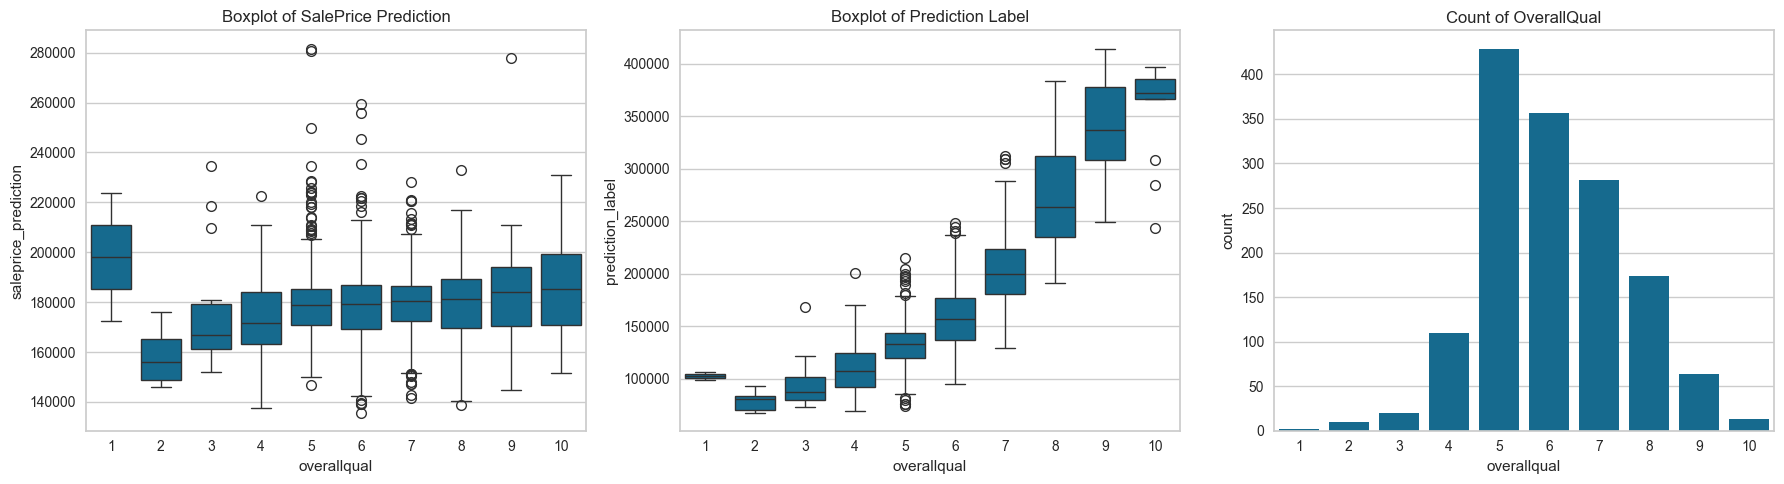

In [42]:
# Set the overall subplot size
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Plot the boxplot of saleprice_prediction in the first subplot
sns.boxplot(x='overallqual', y='saleprice_prediction', data=df_result, ax=axes[0])
axes[0].set_title('Boxplot of SalePrice Prediction')

# Plot the boxplot of prediction_label in the second subplot
sns.boxplot(x='overallqual', y='prediction_label', data=df_result, ax=axes[1])
axes[1].set_title('Boxplot of Prediction Label')

# Plot the count of overallqual in the third subplot
sns.countplot(x='overallqual', data=df_result, ax=axes[2])
axes[2].set_title('Count of OverallQual')

# Adjust the subplot layout
plt.tight_layout()

# Show the plot
plt.show()

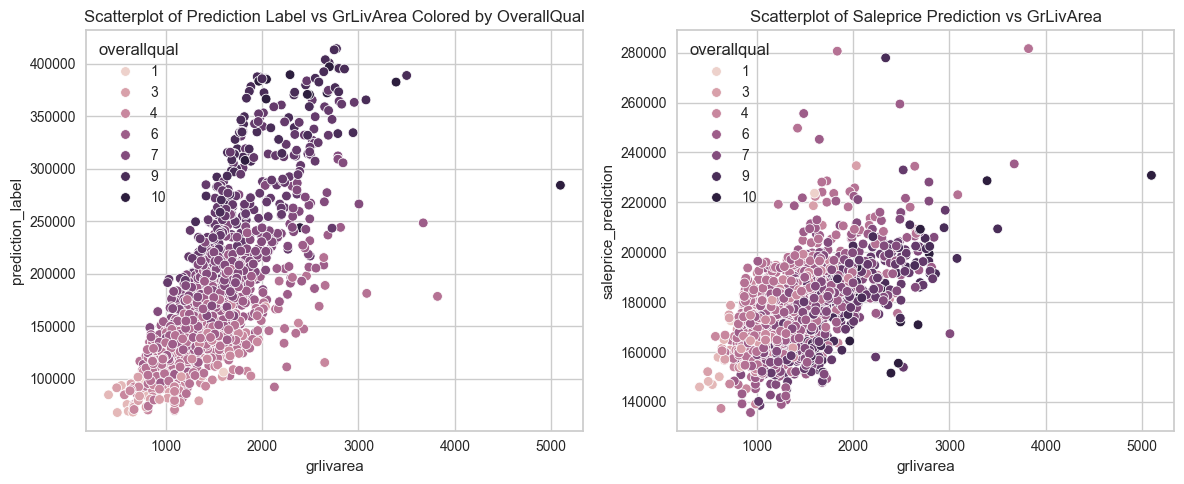

In [51]:
# Plot relation between saleprice_prediction and grlivarea
# Set the overall subplot size
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot the scatterplot of grlivarea and prediction_label in the second subplot
sns.scatterplot(x='grlivarea', y='prediction_label', data=df_result, ax=axes[0], hue='overallqual')
axes[0].set_title('Scatterplot of Prediction Label vs GrLivArea Colored by OverallQual')

# Plot the scatterplot of grlivarea and prediction_label in the second subplot
sns.scatterplot(x='grlivarea', y='saleprice_prediction', data=df_result, ax=axes[1], hue='overallqual')
axes[1].set_title('Scatterplot of Saleprice Prediction vs GrLivArea')

# Adjust the subplot layout
plt.tight_layout()

# Show the plot
plt.show()


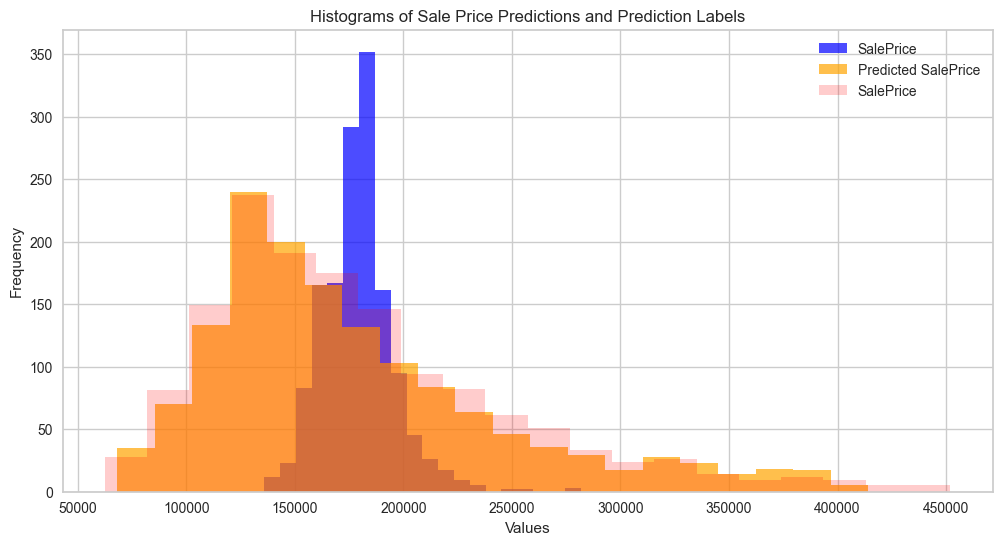

In [34]:
# Set up the figure
plt.figure(figsize=(12, 6))

# Plot the histogram for 'saleprice_prediction'
plt.hist(df_result['saleprice_prediction'], bins=20, color='blue', alpha=0.7, label='SalePrice')

# Plot the histogram for 'prediction_label'
plt.hist(df_result['prediction_label'], bins=20, color='orange', alpha=0.7, label='Predicted SalePrice')

# Plot the histogram for trained saleprice
plt.hist(df['saleprice'], bins=20, color='red', alpha=0.2, label='SalePrice')


# Set titles and labels
plt.title('Histograms of Sale Price Predictions and Prediction Labels')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Add a legend
plt.legend()

# Show the plot
plt.show()